Sources used
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://datascience.stackexchange.com/questions/65979/what-is-the-correct-way-to-call-keras-flow-from-directory-method
* https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
* https://github.com/keras-team/keras/issues/5862#issuecomment-647559571

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# define constants
ORIGINAL_PARENT_DIR = './FRUIT-16K' # enter path to original dataset
PREPROCESSED_PARENT_DIR = './FRUIT-16K-PREPROCESSED' # enter path to folder where you want the preprocessed data to go (code will create it)

CLASSES = []
for directory in os.listdir(ORIGINAL_PARENT_DIR):
    path = os.path.join(ORIGINAL_PARENT_DIR, directory)
    if os.path.isdir(path) and not directory.startswith('.'):
        CLASSES.append(directory)
print(CLASSES)

# define hyper-parameters
BATCH_SIZE = 32
IMAGE_HEIGHT = 244
IMAGE_WIDTH = 244
SEED = 42
TEST_SIZE = 0.2

['F_Banana', 'F_Strawberry', 'F_Tomato', 'F_Orange', 'F_Mango', 'F_Tamarillo', 'F_Lulo', 'S_Tamarillo', 'S_Lulo', 'S_Lemon', 'F_Lemon', 'S_Banana', 'S_Orange', 'S_Tomato', 'S_Strawberry', 'S_Mango']


In [3]:
def get_images_df(path):
    # walk through the path and create a dataframe
    # that has one column for the path to the image
    # and the other with the class name
    images_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if not file.startswith('.'):
                # add to dict [ image | class_name ]
                class_name = root.split(os.sep)[-1]
                image_path = os.path.join(root, file)
                images_data.append({
                    'image_path': image_path,
                    'class': class_name
                })
    df = pd.DataFrame(images_data)
    
    return df

def create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path): 
    # create the train and test folders
    train_path = os.path.join(save_path, 'train')
    test_path = os.path.join(save_path, 'test')
    os.mkdir(train_path)
    os.mkdir(test_path)
        
    # for each class, make a subfolder
    for class_name in classes:
        os.mkdir(os.path.join(train_path, class_name))
        os.mkdir(os.path.join(test_path, class_name))
    
    # transfer files from dataframe image path to the appropriate
    # subfolder in save_path (sub folders based on class name)
    for x_val, y_val in zip(x_train, y_train):
        shutil.copy(x_val, os.path.join(train_path, y_val))
    for x_val, y_val in zip(x_test, y_test):
        shutil.copy(x_val, os.path.join(test_path, y_val))

        
def transfer_data(original_dir, new_dir, classes, test_size):
    # get the images as a dataframe
    # this dataframe has two columns, one with
    # the path to the image in original_dir and one with
    # the class name
    original_df = get_images_df(original_dir)
    
    # split the df into train and test
    x, y = original_df['image_path'], original_df['class']
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = test_size)
    
    # create the new_dir folder
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    
    # transfer all the data from original_df to new_dir
    # with the appropriate formatting
    create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path = new_dir)

In [4]:
transfer_data(ORIGINAL_PARENT_DIR, PREPROCESSED_PARENT_DIR, classes = CLASSES, test_size = TEST_SIZE)

In [5]:
# augment and preprocess the training data
train_image_data_generator = ImageDataGenerator(rescale = 1./255, rotation_range=30,
                                          zoom_range=0.15, width_shift_range=0.2,
                                          height_shift_range=0.2, shear_range=0.15,
                                          horizontal_flip=True, fill_mode="nearest",
                                          zca_epsilon=1e-06)

# do NOT augment the testing data
test_image_data_generator = ImageDataGenerator(rescale = 1./255)

# create the training generator and the testing generator from their respective folders
train_generator = train_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'train'), 
                                                                 target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                                 classes = CLASSES, batch_size = BATCH_SIZE, 
                                                                 shuffle = True, seed = SEED)


test_generator = test_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'test'), 
                                                               target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                               classes = CLASSES, batch_size = BATCH_SIZE, 
                                                               shuffle = True, seed = SEED)

Found 12800 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.


A few potentially useful links/notes for the ML team
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator (check out the Example of using `.flow_from_directory(directory)` section) for how (I think) you can use the fit function with generators)
* You can access the mapping from class to indices through `train_generator.class_indices` or `train_generator.class_indices`
* https://stackoverflow.com/questions/61864244/how-to-avoid-augmenting-data-in-validation-split-of-keras-imagedatagenerator
* https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
* https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

In [6]:
# verify that the class index mapping are the same (should always be the case)
print(test_generator.class_indices == train_generator.class_indices)
print(train_generator.class_indices)

True
{'F_Banana': 0, 'F_Strawberry': 1, 'F_Tomato': 2, 'F_Orange': 3, 'F_Mango': 4, 'F_Tamarillo': 5, 'F_Lulo': 6, 'S_Tamarillo': 7, 'S_Lulo': 8, 'S_Lemon': 9, 'F_Lemon': 10, 'S_Banana': 11, 'S_Orange': 12, 'S_Tomato': 13, 'S_Strawberry': 14, 'S_Mango': 15}


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


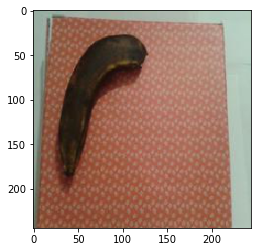

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


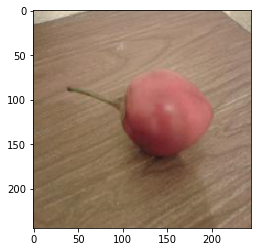

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


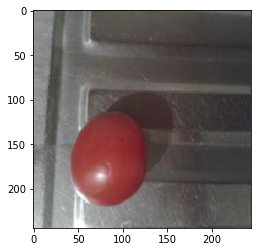

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


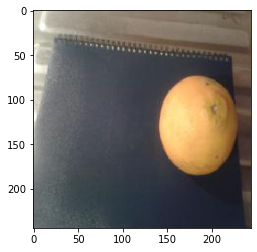

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


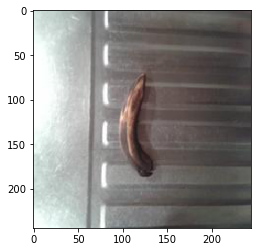

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


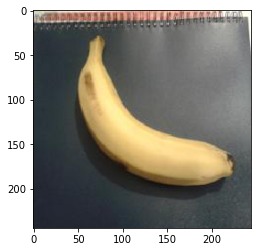

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


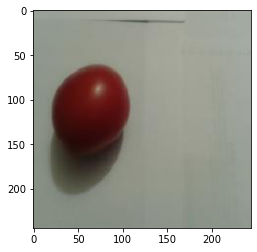

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


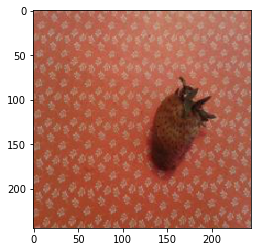

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


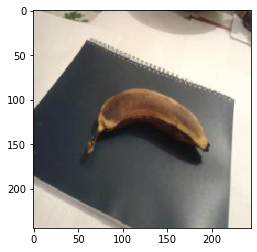

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


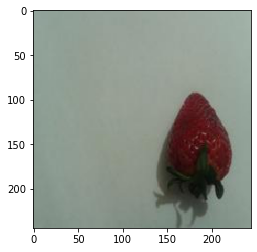

In [7]:
for _ in range(10):
    img, label = test_generator.next()
    print(label[0])
    plt.imshow(img[0])
    plt.show()

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


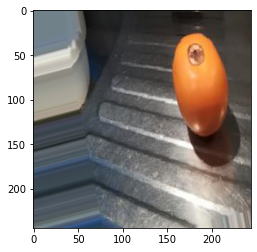

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


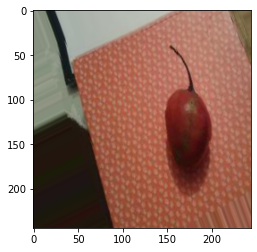

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


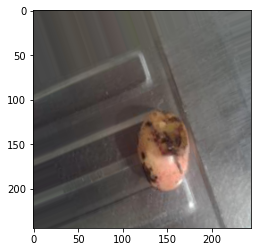

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


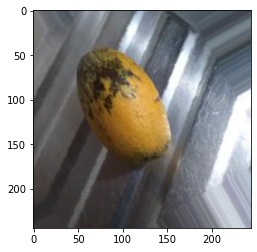

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


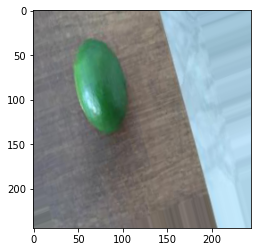

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


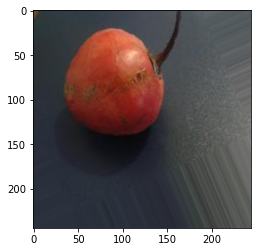

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


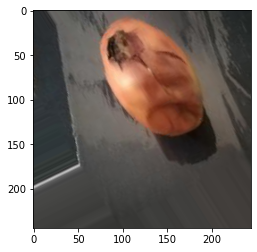

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


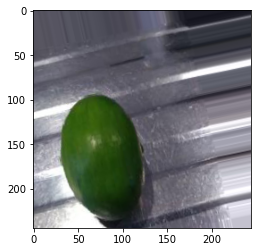

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


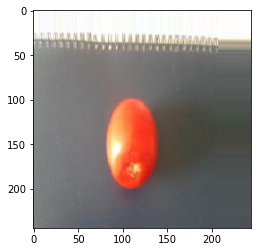

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


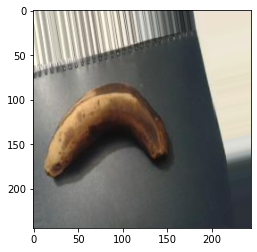

In [8]:
for _ in range(10):
    img, label = train_generator.next()
    print(label[0])
    plt.imshow(img[0])
    plt.show()